In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2,os

In [2]:
tf.__version__

'2.3.0'

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [ ]:
# data_path='/content/drive/MyDrive/Colab Notebooks/dataset/dataset'
data_path='Downloads/dataset-20201210T142510Z-001/dataset/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
# np.save('data',data)
# np.save('target',target)

In [3]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [51]:
data.shape

(1376, 100, 100, 1)

In [52]:
target.shape

(1376,)

In [4]:
img_size=100
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_target,test_size=0.2)

In [6]:
from keras.layers import Dense,Flatten,Dropout,Activation,Conv2D,MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [7]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [44]:
from keras.preprocessing.image import ImageDataGenerator

In [47]:
train_datagen=ImageDataGenerator(rotation_range=45,zoom_range=0.2,horizontal_flip=True,height_shift_range=0.2,width_shift_range=0.2)
test_datagen=ImageDataGenerator()

In [48]:
train_gen=train_datagen.flow(x_train,y_train,batch_size=64)
test_gen=test_datagen.flow(x_test,y_test,batch_size=64)

In [53]:
x_train.shape

(1100, 100, 100, 1)

In [54]:
x_test.shape

(276, 100, 100, 1)

In [55]:
batch=64
checkpoint = ModelCheckpoint('model-{epoch:01d}.h5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='auto')
history=model.fit_generator(train_gen,steps_per_epoch=1100/batch,epochs=20,validation_data=test_gen,validation_steps=276/batch,callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
18/17 [===============================] - ETA: -6s - loss: 0.5394 - accuracy: 0.8127 ETA: 6:26 - loss
Epoch 00001: val_accuracy improved from -inf to 0.93478, saving model to model-1.h5
18/17 [===============================] - 178s 10s/step - loss: 0.5394 - accuracy: 0.8127 - val_loss: 0.1982 - val_accuracy: 0.9348
Epoch 2/20
18/17 [===============================] - ETA: -3s - loss: 0.3606 - accuracy: 0.8700
Epoch 00002: val_accuracy improved from 0.93478 to 0.94565, saving model to model-2.h5
18/17 [===============================] - 76s 4s/step - loss: 0.3606 - accuracy: 0.8700 - val_loss: 0.1822 - val_accuracy: 0.9457
Epoch 3/20
18/17 [===============================] - ETA: -3s - loss: 0.3028 - accuracy: 0.8818
Epoch 00003: val_accuracy improved from 0.94565 to 0.96014, saving model to model-3.h5
18/17 [===============================] - 75s 4s/step - loss: 0.3028 - accuracy: 0.8818 - val_loss:

In [56]:
model.save('mask_and_unmask_2.h5')

In [57]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 5s 509ms/step - loss: 0.0810 - accuracy: 0.9783


[0.08098100870847702, 0.97826087474823]

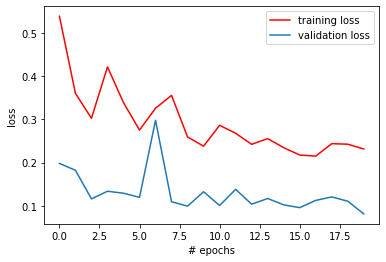

In [58]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

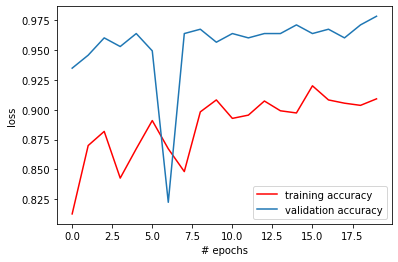

In [59]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [60]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
source=cv2.VideoCapture(0)
print(source.isOpened())
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

True


In [61]:
while(source.isOpened()):
    ret,img=source.read()
#     gray=cv2.cvtColor(img,cv2.COLOR_BRG2GRAY)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#     faces=face_clsfr.detectMultiScale(gray,1.3,5)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==0):
        break
        
cv2.destroyAllWindows()
source.release()